## В данном ноутбуке показан пример обучения модели классификации людей в очках и без

В качестве обучающей выборки используется синтетический датасет с [kaggle](https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses)

In [ ]:
import multiprocessing
import os
import pickle
import sys
import typing
import uuid
import zipfile
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.models import resnet
from tqdm.auto import tqdm

tqdm.pandas()


print(sys.version_info)
print(torch.__version__)
print(torch.cuda.is_available())

In [ ]:
os.environ["WANDB_CONSOLE"] = "off"
# torch.set_num_threads(8)
# torch.set_num_interop_threads(8)

import wandb

In [ ]:
root = "/home/asciishell/s3/jupyter.asciishell.ru"

In [ ]:
df = pd.read_csv(f"{root}/train.csv")[["id", "glasses"]].copy()

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.3, random_state=42)

Используются следующие аугментации для изображений:
- Случайный кроп
- Зеркальное отражение
- Смещение цветов
- Перевод в серый цвет

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
    ]
)


class FaseDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root: str,
        size: tuple[int, int],
        sample: pd.DataFrame,
        transform: typing.Callable,
    ):
        self.root = root
        self.size = size
        self.ids = sample["id"].values
        self.targets = sample["glasses"].values
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img, target = self.ids[index], self.targets[index]
        img = Image.open(self.root.format(img))
        img = img.resize(self.size, Image.Resampling.BILINEAR)

        pos_1 = self.transform(img)
        pos_2 = self.transform(img)

        return pos_1, pos_2, target

In [ ]:
im_size = (224, 224)
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    FaseDataset(f"{root}/faces-spring-2020/faces-spring-2020/face-{{}}.png", im_size, df_train, train_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    FaseDataset(f"{root}/faces-spring-2020/faces-spring-2020/face-{{}}.png", im_size, df_valid, test_transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
)

В качестве базовой модели используется resnet18 с 2 головами - одна для обучения эмбеддингов, вторая для классификации.
Опционально можно выбрать другую базовую модель (resnet34 или 50).

Дополнительно используется NT-Xent loss в SimCLR подходе.
https://arxiv.org/pdf/2002.05709.pdf

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, feature_dim=128, arch="resnet18", init=True):
        super(Model, self).__init__()

        self.f = []

        if arch == "resnet18":
            w = resnet.ResNet18_Weights.DEFAULT if init else None
            module = resnet.resnet18(weights=w)
            in_size = 512
        elif arch == "resnet34":
            w = resnet.ResNet34_Weights.DEFAULT if init else None
            module = resnet.resnet34(weights=w)
            in_size = 512
        elif arch == "resnet50":
            w = resnet.ResNet50_Weights.DEFAULT if init else None
            module = resnet.resnet50(weights=w)
            in_size = 2048
        else:
            raise Exception("Unknown module {}".format(repr(arch)))
        for name, module in module.named_children():
            # if name == "conv1":
            #     module = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            # if not isinstance(module, torch.nn.Linear) and not isinstance(module, torch.nn.MaxPool2d):
            if not isinstance(module, torch.nn.Linear):
                self.f.append(module)
        # encoder
        self.f = torch.nn.Sequential(*self.f)
        self.c = torch.nn.Linear(in_size, 2, bias=True)
        # projection head
        self.g = torch.nn.Sequential(
            torch.nn.Linear(in_size, 512, bias=False),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, feature_dim, bias=True),
        )

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        proba = self.c(feature)
        return F.normalize(out, dim=-1), proba


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, temperature, cuda):
        super().__init__()
        self.temperature = temperature
        self.cuda = cuda

    def get_negative_mask(self, batch_size):
        negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
        for i in range(batch_size):
            negative_mask[i, i] = 0
            negative_mask[i, i + batch_size] = 0

        negative_mask = torch.cat((negative_mask, negative_mask), 0)
        return negative_mask

    def forward(self, out_1, out_2):
        batch_size = out_1.shape[0]

        # neg score
        out = torch.cat([out_1, out_2], dim=0)
        neg = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)
        mask = self.get_negative_mask(batch_size)
        if self.cuda:
            mask = mask.cuda()
        neg = neg.masked_select(mask).view(2 * batch_size, -1)

        # pos score
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / self.temperature)
        pos = torch.cat([pos, pos], dim=0)

        # estimator g()
        Ng = neg.sum(dim=-1)

        # contrastive loss
        loss = (-torch.log(pos / (pos + Ng))).mean()

        return loss

In [ ]:
def main(
    *,
    model,
    criterion_cls,
    criterion_contrastive,
    optimizer,
    writer,
    train_loader,
    valid_loader,
    checkpoint_path,
    cuda=True,
    epochs=200,
    alpha=0.1,
):
    if cuda:
        model = model.cuda()
    model = torch.nn.DataParallel(model)
    step = 0
    for epoch in range(1, epochs + 1):
        epoch_alpha = alpha + (1.0 - alpha) * (epoch / epochs)
        writer.add_scalar("train/alpha", epoch_alpha, epoch)
        model.train()
        total_loss, total_num = 0.0, 0
        for pos_1, pos_2, target in tqdm(train_loader, desc=f"Train {epoch}"):
            if cuda:
                pos_1 = pos_1.cuda(non_blocking=True)
                pos_2 = pos_2.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
            out_1, out_1_proba = model(pos_1)
            out_2, out_2_proba = model(pos_2)

            loss = epoch_alpha * (criterion_cls(out_1_proba, target) + criterion_cls(out_2_proba, target)) + (
                1.0 - epoch_alpha
            ) * criterion_contrastive(out_1, out_2)
            writer.add_scalar("loss/train", loss, step)
            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_num += batch_size
            total_loss += loss.item() * batch_size

        train_loss = total_loss / total_num

        if epoch % 1 == 0:
            with torch.no_grad():
                model.eval()
                predicts = []
                targets = []
                for pos_1, pos_2, target in tqdm(valid_loader, desc=f"Valid {epoch}"):
                    if cuda:
                        pos_1 = pos_1.cuda(non_blocking=True)
                    _, predict = model(pos_1)
                    predicts.extend(predict.cpu().numpy())
                    targets.extend(target.cpu().numpy())
            predicts = np.stack(predicts)
            targets = np.stack(targets)
            writer.add_scalar("valid/f1w", f1_score(targets, predicts.argmax(axis=1), average="weighted"), epoch)
            writer.add_scalar("valid/acc", accuracy_score(targets, predicts.argmax(axis=1)), epoch)
            writer.add_scalar(
                "valid/roc_auc",
                roc_auc_score(targets, scipy.special.softmax(predicts, axis=1)[:, 1]),
                epoch,
            )
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
        writer.flush()
    writer.close()

In [ ]:
def main2():
    cuda = False
    epochs = 10
    model_arch = "resnet18"
    init = True
    cls_w = 0.5
    run = f"glass-{model_arch}-init={init}-cls_w={cls_w}-bs={batch_size}"
    os.makedirs(run, exist_ok=True)
    wandb.init(
        project="glasses_cv",
        dir=run,
        name=run,
        config={
            "model": model_arch,
            "init": init,
            "classification_weight": cls_w,
            "batch_size": batch_size,
            "epochs": epochs,
        },
    )
    wandb.tensorboard.patch(root_logdir=run)
    writer = SummaryWriter(run)

    model = Model(64, model_arch, init)
    criterion_cls = torch.nn.CrossEntropyLoss()
    criterion_contrastive = ContrastiveLoss(0.5, cuda)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    print("Start", run)
    main(
        model=model,
        criterion_cls=criterion_cls,
        criterion_contrastive=criterion_contrastive,
        optimizer=optimizer,
        writer=writer,
        train_loader=train_loader,
        valid_loader=test_loader,
        checkpoint_path=f"{run}/model_{{}}.pt",
        cuda=cuda,
        epochs=epochs,
        alpha=cls_w,
    )

    writer.close()
    wandb.finish()
    wandb.tensorboard.unpatch()


if __name__ == "__main__":
    main2()

Получаем предсказания модели

In [10]:
model = Model(64, arch="resnet18")
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('./glass-resnet18-init=True-cls_w=0.5-bs=128/model_9.pt'))
model.eval();

In [11]:
def predict_with_model(model, images):
    if isinstance(images, Image.Image):
        images = [images]
    images = [img.resize((224, 224), Image.Resampling.BILINEAR) for img in images]
    test_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        ]
    )
    images = torch.stack([test_transforms(img) for img in images], dim=0)
    with torch.no_grad():
        emb, proba = model(images)
    proba = scipy.special.softmax(proba, axis=1)
    return emb.cpu().numpy(), proba.cpu().numpy()

0.00019684115


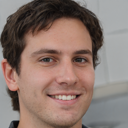

In [15]:
img = Image.open(f"{root}/faces-spring-2020/faces-spring-2020/face-1.png")
_, proba = predict_with_model(model, img)
print(proba[0][1])
img.resize((128, 128))